Map:   0%|          | 0/576187 [00:00<?, ? examples/s]

Map:   0%|          | 0/144047 [00:00<?, ? examples/s]

Map:   0%|          | 0/576187 [00:00<?, ? examples/s]

Map:   0%|          | 0/144047 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/masood/Projects/test_3/.venv/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4384/2601280271.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.642500,0.620916,0.748006,0.598942
2,0.505000,0.619476,0.753449,0.617205


Evaluation results: {'eval_loss': 0.6194759607315063, 'eval_accuracy': 0.7534485272168112, 'eval_macro_f1': 0.6172052692375657, 'eval_runtime': 4977.0512, 'eval_samples_per_second': 28.942, 'eval_steps_per_second': 0.905, 'epoch': 2.0}


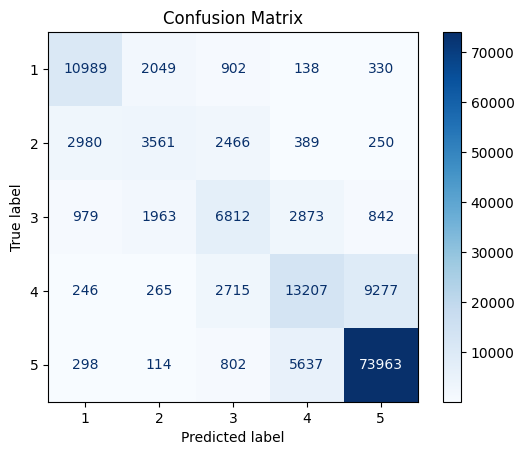

Device set to use cuda:0


Predicted Rating: 5


In [ ]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate  # Use the 'evaluate' package instead of 'datasets' for metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Features, Value
import accelerate

features = Features({
    'reviewText': Value('string'),
    'overall': Value('int64')
})

dataset = load_dataset('csv', data_files='./data/train_data.csv', split='train', features=features)

def filter_long_reviews(example):
    return len(example['reviewText']) <= 1000

filtered_dataset = dataset.filter(filter_long_reviews)

train_test_split = filtered_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test']
})

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    return tokenizer(examples['reviewText'], truncation=True, padding=True, max_length=512)

encoded_dataset = dataset.map(preprocess_function, batched=True)

encoded_dataset = encoded_dataset.map(lambda x: {'label': x['overall'] - 1})

train_dataset = encoded_dataset['train'].shuffle(seed=42).select(range(100000))
val_dataset = encoded_dataset['validation']

num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    macro_f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    
    return {
        "accuracy": accuracy["accuracy"],
        "macro_f1": macro_f1["f1"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

trainer.save_model("./fine_tuned_model")

predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [5]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     14408
           1       0.45      0.37      0.40      9646
           2       0.50      0.51      0.50     13469
           3       0.59      0.51      0.55     25710
           4       0.87      0.92      0.89     80814

    accuracy                           0.75    144047
   macro avg       0.62      0.61      0.62    144047
weighted avg       0.74      0.75      0.75    144047



In [ ]:
from transformers import pipeline

sentiment_analysis = pipeline("text-classification", model="./fine_tuned_model")

reviews = [
    "This product is amazing! I love it!",
    "The quality is terrible, and it broke after one use.",
    "It's okay, not the best but not the worst either.",
    "Absolutely fantastic! Exceeded my expectations!",
    "Not what I expected. Very disappointing."
]

for i, review in enumerate(reviews, 1):
    prediction = sentiment_analysis(review)
    predicted_label = prediction[0]['label']
    predicted_rating = int(predicted_label.split('_')[-1]) + 1
    
    print(f"Review {i}: {review}")
    print(f"Predicted Rating: {predicted_rating}\n")

Device set to use cuda:0


Review 1: This product is amazing! I love it!
Predicted Rating: 5

Review 2: The quality is terrible, and it broke after one use.
Predicted Rating: 1

Review 3: It's okay, not the best but not the worst either.
Predicted Rating: 3

Review 4: Absolutely fantastic! Exceeded my expectations!
Predicted Rating: 5

Review 5: Not what I expected. Very disappointing.
Predicted Rating: 2

